In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/libraries.py /content
import libraries


In [ ]:
!pip install torchviz
!pip install torchsummary
!apt-get install graphviz -y
!pip install graphviz
!pip install Pillow
from torchviz import make_dot


In [ ]:
# Define the data path
DATA_PATH = '/content/drive/MyDrive/sipakmed/sipakmed/'

In [ ]:
# Import the module
!cp /content/drive/MyDrive/sipakmed/modular/dataset_management.py /content

import dataset_management


i used this to make sure there isn't duplicated data and data for training was succesful and splitting dataset

i used this to check now how many files i have knowing that my data for sipakmed originally were 4049 bmb files

In [ ]:
# Get a list of all image file paths
file_paths = []
categories = []

for root, dirs, files in libraries.os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.bmp'):
            file_path = libraries.os.path.join(root, file)
            file_paths.append(file_path)
            if 'normal' in file_path:
                categories.append(0)
            else:
                categories.append(1)

In [ ]:
import libraries
df = libraries.pd.DataFrame({'filename (X)': file_paths, 'category (Y)': categories})
df

In [ ]:
import os
import shutil
import random
# Specify the path to your dataset on Google Drive
drive_path = '/content/drive/MyDrive/sipakmed/sipakmed/'

# Define the output directory for your divided dataset on Google Drive
output_dir = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training'


to check if my data are balanced regarding the training ones or not

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/sipakmed/modular')

import check_balanced_data
check_balanced_data.check_balanced_data()


data balance in normal and atypical

In [ ]:
# Function to balance data by randomly undersampling the majority class
def balance_data(train_files):
    normal_files = [file for file in train_files if 'normal' in file]
    atypical_files = [file for file in train_files if 'atypical' in file]

    min_samples = min(len(normal_files), len(atypical_files))

    balanced_data = random.sample(normal_files, min_samples) + random.sample(atypical_files, min_samples)
    return balanced_data


In [ ]:
def check_balance(data):
    normal_count = sum(1 for file in data if 'normal' in file)
    atypical_count = sum(1 for file in data if 'atypical' in file)

    return normal_count, atypical_count

# Call the balance_data function to get the balanced dataset
balanced_train_data = balance_data(train_files)

# Check the balance
normal_count, atypical_count = check_balance(balanced_train_data)
print(f"Normal samples: {normal_count}, Atypical samples: {atypical_count}")

if normal_count == atypical_count:
    print("The data is balanced.")
else:
    print("The data is not balanced.")


Normal samples: 2179, Atypical samples: 2179
The data is balanced.


Data preprocessing and loading using torchvision


 load images and their labels from the balanced_dataset:

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/data_loading.py /content
import data_loading

Do you want to apply data processing? (y/n): n
Data processing skipped.
Number of images in 'normal' class: 1159
Number of images in 'atypical' class: 1005


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import os
from torchvision.models import mobilenet_v3_small
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

# Model
class MobileNetV3Small(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3Small, self).__init__()
        self.model = mobilenet_v3_small(pretrained=True)
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Dataset
class PTImageDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = self.get_files(data_dir)
        self.num_classes = 2  # Assuming you have 2 classes
        self.class_names = ["normal", "abnormal"]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img_tensor = torch.load(img_path)

        # Extract label from the file path or filename
        label = self.extract_label(img_path)

        return img_tensor, label

    def extract_label(self, file_path):
        # Modify this logic based on your actual file naming or directory structure
        parts = file_path.split(os.path.sep)
        class_name = parts[-2]
        return 0 if class_name == "normal" else 1  # Adjust based on your class names

    def get_files(self, data_dir):
        all_files = []
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith(".pt"):
                    all_files.append(os.path.join(root, file))
        return all_files


In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        epoch_acc += correct / total

    epoch_loss /= len(train_loader.dataset)
    epoch_acc /= len(train_loader.dataset)

    return epoch_loss, epoch_acc

# Placeholder for the test function
def test(model, test_loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            epoch_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            epoch_acc += correct

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss /= len(test_loader.dataset)
    epoch_acc /= len(test_loader.dataset)

    return epoch_loss, epoch_acc, all_preds, all_labels

# Dataset and dataloaders
PREPROCESSED_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/preprocessed_classified/"
dataset = PTImageDataset(PREPROCESSED_PATH)
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import os
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from torchvision.models import mobilenet_v3_small

# Model, optimizer, loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3Small().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Check if a pre-trained model should be loaded
load_pretrained = input("Do you want to load a pre-trained model? (yes/no): ").lower()

if load_pretrained == "yes":
    # Check if a previously saved model exists
    saved_model_path = "mobilenetv3_small.pth"  # Adjust the filename as needed
    if os.path.exists(saved_model_path):
        model = MobileNetV3Small().to(device)
        model.load_state_dict(torch.load(saved_model_path))
        print("Pre-trained model loaded.")
    else:
        print(f"No pre-trained model found at {saved_model_path}. Training a new model.")
        load_pretrained = "no"

if load_pretrained != "yes":
    # Training loop
    train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
for epoch in range(50):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = test(model, val_loader, criterion)
    print(f"Epoch {epoch + 1} - "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}")
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_acc)
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve == patience:
        print("Early stopping!")
        break
# Testing
test_loss, test_acc, test_preds, test_labels = test(model, test_loader, criterion)
print(f"Final Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")



Do you want to load a pre-trained model? (yes/no): n
Epoch 1 - Train Loss: 0.6400 Train Acc: 0.0405 Validation Loss: 0.6148 Validation Acc: 0.6667
Epoch 2 - Train Loss: 0.5006 Train Acc: 0.0515 Validation Loss: 0.5327 Validation Acc: 0.7708
Epoch 3 - Train Loss: 0.4187 Train Acc: 0.0528 Validation Loss: 0.4114 Validation Acc: 0.8611
Epoch 4 - Train Loss: 0.3696 Train Acc: 0.0549 Validation Loss: 0.3382 Validation Acc: 0.8889
Epoch 5 - Train Loss: 0.3289 Train Acc: 0.0554 Validation Loss: 0.3040 Validation Acc: 0.8981
Epoch 6 - Train Loss: 0.2989 Train Acc: 0.0564 Validation Loss: 0.2673 Validation Acc: 0.9074
Epoch 7 - Train Loss: 0.2507 Train Acc: 0.0573 Validation Loss: 0.2452 Validation Acc: 0.9167
Epoch 8 - Train Loss: 0.2512 Train Acc: 0.0574 Validation Loss: 0.2251 Validation Acc: 0.9213
Epoch 9 - Train Loss: 0.2345 Train Acc: 0.0573 Validation Loss: 0.2075 Validation Acc: 0.9282
Epoch 10 - Train Loss: 0.2170 Train Acc: 0.0575 Validation Loss: 0.2031 Validation Acc: 0.9259
Epoch 

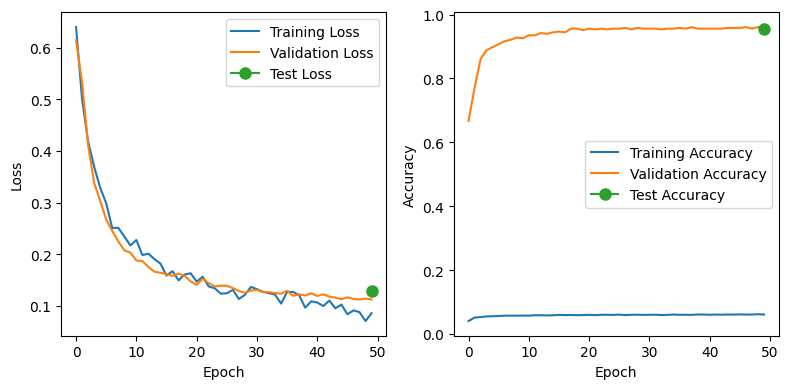

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/acc_loss_curves.py /content
import acc_loss_curves

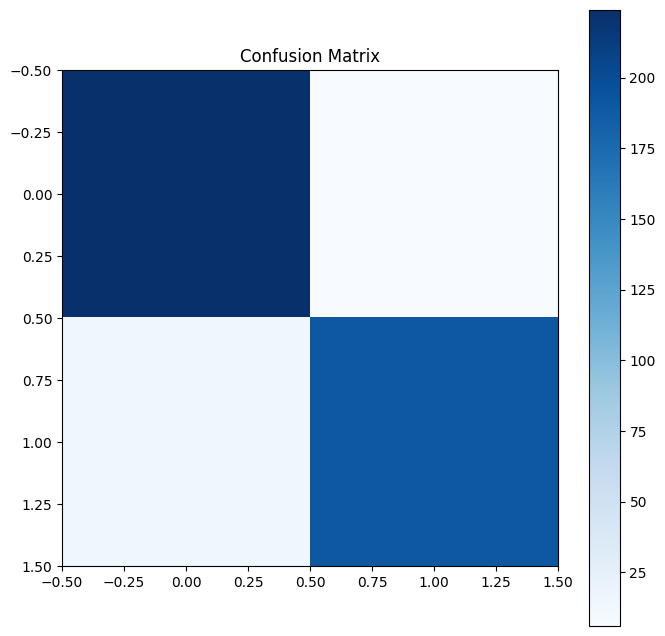

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/confusion_matrix.py /content
import confusion_matrix

In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/evaluation_metrics.py /content
import evaluation_metrics


F1 Score: 0.9539
Precision: 0.9544
Recall: 0.9539
Classification Report:
               precision    recall  f1-score   support

      normal       0.94      0.97      0.96       230
    abnormal       0.97      0.93      0.95       204

    accuracy                           0.95       434
   macro avg       0.96      0.95      0.95       434
weighted avg       0.95      0.95      0.95       434

Do you want to save the trained model? (yes/no): y


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of trainable parameters in the model: {num_params}")


Number of trainable parameters in the model: 1519906


In [ ]:
!cp /content/drive/MyDrive/sipakmed/modular/sample_input_time.py /content
import sample_input_time

Inference time for a sample input: 0.017484664916992188 seconds


In [ ]:
from torchsummary import summary

# Instantiate the model
model = mobilenet_v3_small()

# Define a function to print a concise summary
def concise_summary(model, input_size):
    summary(model, input_size, device="cuda" if torch.cuda.is_available() else "cpu")

# Print the concise summary
input_size = (3, 125, 125)
concise_summary(model, input_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 63, 63]             432
       BatchNorm2d-2           [-1, 16, 63, 63]              32
         Hardswish-3           [-1, 16, 63, 63]               0
            Conv2d-4           [-1, 16, 32, 32]             144
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]             256
      BatchNorm2d-14           [-1, 16,